In [3]:
# Library imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
def mse(data, betas):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        u = betas[0] + np.dot(betas[1:], data[i][:cols - 1].T)
        loss += pow(data[i][cols - 1] - u, 2)
    loss *= 1 / rows
    return loss

def iterate(data_train, data_test, betas, epochs, learning_rate):
    metrics = {
        'loss_train': [mse(data_train, betas)],
        'loss_test': [mse(data_test, betas)],
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            temp = data_train[i, cols - 1] - (betas[0] + np.dot(betas[1:], data_train[i][:cols - 1].T))
            dbetas[0] += temp
            dbetas[1:] += temp * data_train[i][:cols - 1]
        dbetas *= -2 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(mse(data_train, betas))
        metrics['loss_test'].append(mse(data_test, betas))
    return metrics

In [9]:
data = pd.read_csv('linreg_data.csv').to_numpy()
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [24]:
eps = 100
lr = 0.1
betas = np.zeros(train.shape[1])

metrics = iterate(train, test, betas, eps, lr)

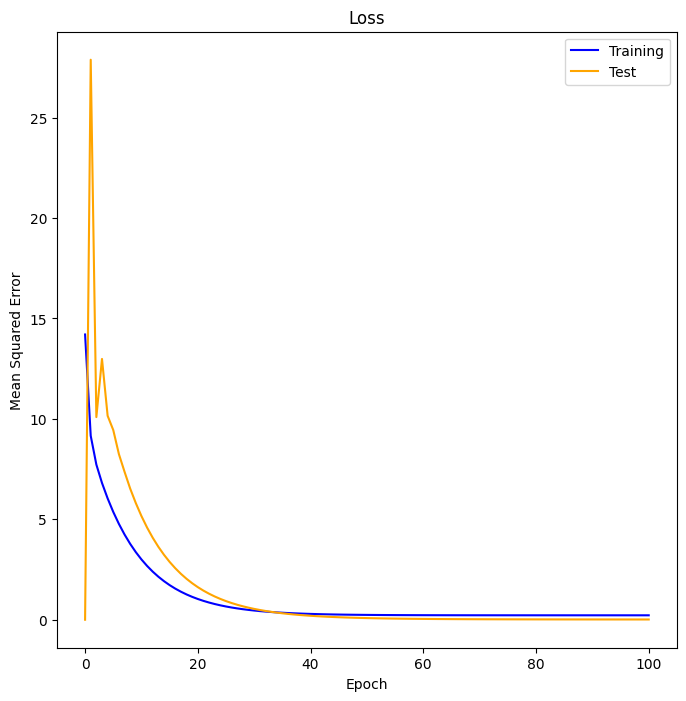

In [32]:
plt.figure(figsize=(8, 8))
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [30]:
print(metrics['loss_train'][eps])

0.2200429678585119
